<a href="https://colab.research.google.com/github/mbui0529/GradientDescentOptimizer/blob/master/FinalProject_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EE 510: Deep Learning Theory and Practice
### Project -- Adam / Optimizers
### Ali Al-Bayaty, Matthew Bui, Sharanya Durgadasa
### 3/13/2020

## Classification of synthetic and benchmark datasets using MLP (Multi-Layer Perceptron) and a set of optimizers.


In [0]:
# Loading the required libraries:
import time
import numpy as np
import sklearn as skl
from sklearn import datasets
import torch
from torch.optim import Optimizer
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.datasets as dsets 
import torchvision.transforms as transforms 
from torch.autograd import Variable
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline
plt.ion()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Defining the hyperparameters for the model architecture:

In [0]:
# Model Hyper Parameters:
input_size = 784
num_classes = 10
num_epochs = 30
batch_size = 128
learning_rate = 0.01
num_features = 2
num_hidden   = 100
num_input = input_size
beta1 = 0.9
beta2 = 0.99

### Define Nadam Optimizer

In [0]:
class Nadam(Optimizer):
    """Implements Nadam algorithm (a variant of Adam based on Nesterov momentum).

    It has been proposed in `Incorporating Nesterov Momentum into Adam`__.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 2e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        schedule_decay (float, optional): momentum schedule decay (default: 4e-3)

    __ http://cs229.stanford.edu/proj2015/054_report.pdf
    __ http://www.cs.toronto.edu/~fritz/absps/momentum.pdf
    """

    def __init__(self, params, lr=2e-3, betas=(beta1, beta2), eps=1e-8,
                 weight_decay=0, schedule_decay=4e-3):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, schedule_decay=schedule_decay)
        super(Nadam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['m_schedule'] = 1.
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                # Warming momentum schedule
                m_schedule = state['m_schedule']
                schedule_decay = group['schedule_decay']
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                eps = group['eps']
                state['step'] += 1
                t = state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                momentum_cache_t = beta1 * \
                    (1. - 0.5 * (0.96 ** (t * schedule_decay)))
                momentum_cache_t_1 = beta1 * \
                    (1. - 0.5 * (0.96 ** ((t + 1) * schedule_decay)))
                m_schedule_new = m_schedule * momentum_cache_t
                m_schedule_next = m_schedule * momentum_cache_t * momentum_cache_t_1
                state['m_schedule'] = m_schedule_new

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1. - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1. - beta2, grad, grad)
                exp_avg_sq_prime = exp_avg_sq / (1. - beta2 ** t)
                denom = exp_avg_sq_prime.sqrt_().add_(eps)

                p.data.addcdiv_(-group['lr'] * (1. - momentum_cache_t) / (1. - m_schedule_new), grad, denom)
                p.data.addcdiv_(-group['lr'] * momentum_cache_t_1 / (1. - m_schedule_next), exp_avg, denom)

        return loss


## Generating a synthetic dataset:
Creates a synthetic dataset using a dataset generator from the open source scikit-learn machine learning library.  It will generate a number of 2-D clusters (blobs) of data (i.e., classes) by drawing from a number of isotropic Gaussian distributions with different center locations (means) and std dev = 1.0.

In [0]:
def generate_synthetic_data(dataset_size=10000, train_split = 0.1, num_blobs=num_classes, n_features=num_features, cluster_std_dev=1.0, center_box=(-8., 8.), random_state=10):
    # scatter plot of blobs dataset
    # generate 2d classification dataset
    X, y = datasets.make_blobs(n_samples=dataset_size, centers=num_blobs, n_features=2, cluster_std=cluster_std_dev, center_box=(-8., 8.), random_state=10)
    # scatter plot for each class value
    for class_value in range(num_blobs):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()
    # zip the datapoints with their labels and split the dataset into training and validation sets
    y2 = y.reshape(dataset_size,1)
    all_data = np.hstack([X,y2]) # Returns an array with [x1, x2, one-hot class label] in each row
    n_train = int(train_split*dataset_size)
    training_data = all_data[:n_train, :]
    validation_data = all_data[n_train:, :]
    return training_data, validation_data

## Loading the synthetic training and validation datasets:

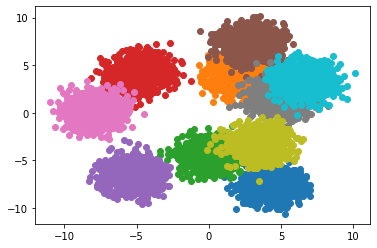

Number of synthetic training data   = 1000
Number of synthetic validation data = 9000



In [0]:
# Loading the synthetic dataset:
synthetic_train_data, synthetic_val_data = generate_synthetic_data(train_split = 0.1)
num_train= len(synthetic_train_data)
num_val  = len(synthetic_val_data)

# Prepare dataset loaders (input pipeline):
synthetic_train_loader = torch.utils.data.DataLoader(dataset = synthetic_train_data, batch_size = 64, shuffle = True) 
synthetic_val_loader   = torch.utils.data.DataLoader(dataset = synthetic_val_data, batch_size = num_val, shuffle = False)

print(f'Number of synthetic training data   = {num_train}')
print(f'Number of synthetic validation data = {num_val}', end='\n\n')

## The MLP architecture:

In [0]:
class MLP(nn.Module):
    def __init__(self, num_input, num_classes): 
        super(MLP, self).__init__() 
        self.hidden1 = nn.Linear(num_input, num_hidden)
        self.hidden2 = nn.Linear(num_hidden, num_hidden)
        #self.hidden3 = nn.Linear(num_hidden, num_hidden)
        self.output  = nn.Linear(num_hidden, num_classes)
        
    def forward(self, x): 
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        #x = F.relu(self.hidden3(x))
        out = self.output(x)
        return out

## Initializing the model:

In [0]:
model = MLP(num_features, num_classes)
model.to(device)

MLP(
  (hidden1): Linear(in_features=2, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
)

### Computing the average loss for one epoch:

In [0]:
def synthetic_epoch_loss(data, model, criterion):
    
    data_points = Variable(torch.from_numpy(data[:, 0:2])).float().to(device) 
    labels = Variable(torch.from_numpy(data[:, 2:3])).long().squeeze().to(device) # remove a dim
    outputs = model(data_points)
    
    return criterion(outputs, labels).cpu().detach().numpy()

## One epoch of synthetic training loop:

In [0]:
def synthetic_train_epoch(loader, model):

    start_time = time.time()

    # Iterate through the batches in loader:
    for i, data in enumerate(loader):
        
        datapoints = Variable(data[:, 0:2]).float().to(device) 
        labels = Variable(data[:, 2:3]).long().squeeze().to(device)

        # Forward + Backward + Optimize:
        optimizer.zero_grad() 
        outputs = model(datapoints)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
    
    return (time.time() - start_time)

## Evaluating the synthetic classification accuracy:

In [0]:
def synthetic_classification_accuracy(loader, model, OptimType):

    correct = 0
    total = 0

    for i, data in enumerate(loader):
        data_points = Variable(data[:, 0:2]).float().to(device) 
        labels = Variable(data[:, 2:3]).long().squeeze().to(device) # remove a dim
        outputs = model(data_points)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum()

    print(f'MLP model accuracy on {total} synthetic datapoints using {OptimType} = {100 * correct / total: d}%')

## Training the model using synthetic datasets and different optimizers:

In [0]:
# Loss function:
criterion = nn.CrossEntropyLoss()

# -------------------------------------------------------------------
# Train the model with SGD optimizer using synthetic dataset:

# New model instance:
model = MLP(num_features, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

synthetic_train_loss_SGD = np.zeros((num_epochs,1))
synthetic_val_loss_SGD   = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = synthetic_train_epoch(synthetic_train_loader, model)
    computational_cost += diff_time

    # Computing the synthetic training and validation losses for one epoch:
    synthetic_train_loss_SGD[epoch] = synthetic_epoch_loss(synthetic_train_data, model, criterion)
    synthetic_val_loss_SGD[epoch]   = synthetic_epoch_loss(synthetic_val_data, model, criterion)

synthetic_classification_accuracy(synthetic_val_loader, model, 'SGD')
print(f'Computational training cost (MLP model + SGD) took ({computational_cost:.3f}) seconds.%', end='\n\n')

# -------------------------------------------------------------------
# Train the model with Adam optimizer using synthetic dataset:

# New model instance:
model = MLP(num_features, num_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas=(beta1, beta2))
computational_cost = 0
diff_time = 0

synthetic_train_loss_Adam = np.zeros((num_epochs,1))
synthetic_val_loss_Adam   = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = synthetic_train_epoch(synthetic_train_loader, model)
    computational_cost += diff_time

    # Computing the synthetic training and validation losses for one epoch:
    synthetic_train_loss_Adam[epoch] = synthetic_epoch_loss(synthetic_train_data, model, criterion)
    synthetic_val_loss_Adam[epoch]   = synthetic_epoch_loss(synthetic_val_data, model, criterion)

synthetic_classification_accuracy(synthetic_val_loader, model, 'Adam')
print(f'Computational training cost (MLP model + Adam) took ({computational_cost:.3f}) seconds.%', end='\n\n')

# -------------------------------------------------------------------
# Train the model with AdaGrad optimizer using synthetic dataset:

# New model instance:
model = MLP(num_features, num_classes)
model.to(device)

optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

synthetic_train_loss_AdaGrad = np.zeros((num_epochs,1))
synthetic_val_loss_AdaGrad   = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = synthetic_train_epoch(synthetic_train_loader, model)
    computational_cost += diff_time

    # Computing the synthetic training and validation losses for one epoch:
    synthetic_train_loss_AdaGrad[epoch] = synthetic_epoch_loss(synthetic_train_data, model, criterion)
    synthetic_val_loss_AdaGrad[epoch]   = synthetic_epoch_loss(synthetic_val_data, model, criterion)

synthetic_classification_accuracy(synthetic_val_loader, model, 'AdaGrad')
print(f'Computational training cost (MLP model + AdaGrad) took ({computational_cost:.3f}) seconds.%', end='\n\n')

# -------------------------------------------------------------------
# Train the model with RMSProp optimizer using synthetic dataset:

# New model instance:
model = MLP(num_features, num_classes)
model.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

synthetic_train_loss_RMSProp = np.zeros((num_epochs,1))
synthetic_val_loss_RMSProp   = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = synthetic_train_epoch(synthetic_train_loader, model)
    computational_cost += diff_time

    # Computing the synthetic training and validation losses for one epoch:
    synthetic_train_loss_RMSProp[epoch] = synthetic_epoch_loss(synthetic_train_data, model, criterion)
    synthetic_val_loss_RMSProp[epoch]   = synthetic_epoch_loss(synthetic_val_data, model, criterion)

synthetic_classification_accuracy(synthetic_val_loader, model, 'RMSProp')
print(f'Computational training cost (MLP model + RMSProp) took ({computational_cost:.3f}) seconds.%', end='\n\n')

MLP model accuracy on 9000 synthetic datapoints using SGD =  84%
Computational training cost (MLP model + SGD) took (0.773) seconds.%

MLP model accuracy on 9000 synthetic datapoints using Adam =  93%
Computational training cost (MLP model + Adam) took (0.974) seconds.%

MLP model accuracy on 9000 synthetic datapoints using AdaGrad =  92%
Computational training cost (MLP model + AdaGrad) took (0.683) seconds.%

MLP model accuracy on 9000 synthetic datapoints using RMSProp =  93%
Computational training cost (MLP model + RMSProp) took (0.718) seconds.%



### Train model with classic momentum using synthetic dataset.

In [0]:
# -------------------------------------------------------------------
# Train the model with SGD momentum optimizer using synthetic dataset:

# New model instance:
model = MLP(num_features, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum= beta1)
computational_cost = 0
diff_time = 0

synthetic_train_loss_Mo = np.zeros((num_epochs,1))
synthetic_val_loss_Mo   = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = synthetic_train_epoch(synthetic_train_loader, model)
    computational_cost += diff_time

    # Computing the synthetic training and validation losses for one epoch:
    synthetic_train_loss_Mo[epoch] = synthetic_epoch_loss(synthetic_train_data, model, criterion)
    synthetic_val_loss_Mo[epoch]   = synthetic_epoch_loss(synthetic_val_data, model, criterion)

synthetic_classification_accuracy(synthetic_val_loader, model, 'SGD with Momentum')
print(f'Computational training cost (MLP model + SGD + Momumtum) took ({computational_cost:.3f}) seconds.%', end='\n\n')


MLP model accuracy on 9000 synthetic datapoints using SGD with Momentum =  93%
Computational training cost (MLP model + SGD + Momumtum) took (0.625) seconds.%



### Train model with NAG using synthetic dataset.

In [0]:
# -------------------------------------------------------------------
# Train the model with NAG optimizer using synthetic dataset:

# New model instance:
model = MLP(num_features, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum= beta1, nesterov=True)
computational_cost = 0
diff_time = 0

synthetic_train_loss_NAG = np.zeros((num_epochs,1))
synthetic_val_loss_NAG   = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = synthetic_train_epoch(synthetic_train_loader, model)
    computational_cost += diff_time

    # Computing the synthetic training and validation losses for one epoch:
    synthetic_train_loss_NAG[epoch] = synthetic_epoch_loss(synthetic_train_data, model, criterion)
    synthetic_val_loss_NAG[epoch]   = synthetic_epoch_loss(synthetic_val_data, model, criterion)

synthetic_classification_accuracy(synthetic_val_loader, model, ' NAG')
print(f'Computational training cost (MLP model + NAG) took ({computational_cost:.3f}) seconds.%', end='\n\n')


MLP model accuracy on 9000 synthetic datapoints using  NAG =  93%
Computational training cost (MLP model + NAG) took (0.778) seconds.%



### Train model with Nadam using synthetic dataset.

Training Nadam

In [0]:
# -------------------------------------------------------------------
# Train the model with Nadam optimizer using synthetic dataset:

# New model instance:
model = MLP(num_features, num_classes)
model.to(device)

optimizer = Nadam(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

synthetic_train_loss_Nadam = np.zeros((num_epochs,1))
synthetic_val_loss_Nadam   = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = synthetic_train_epoch(synthetic_train_loader, model)
    computational_cost += diff_time

    # Computing the synthetic training and validation losses for one epoch:
    synthetic_train_loss_Nadam[epoch] = synthetic_epoch_loss(synthetic_train_data, model, criterion)
    synthetic_val_loss_Nadam[epoch]   = synthetic_epoch_loss(synthetic_val_data, model, criterion)

synthetic_classification_accuracy(synthetic_val_loader, model, ' Nadam')
print(f'Computational training cost (MLP model + Nadam) took ({computational_cost:.3f}) seconds.%', end='\n\n')


MLP model accuracy on 9000 synthetic datapoints using  Nadam =  92%
Computational training cost (MLP model + Nadam) took (0.834) seconds.%



## Plotting the synthetic losses:

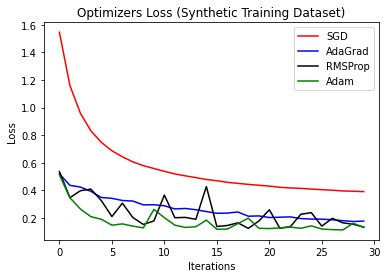

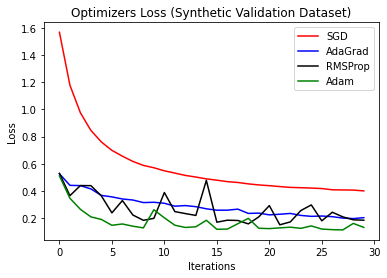

In [0]:
# Setting up the matplotlib plot:
x_axis = range(0,num_epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, synthetic_train_loss_SGD, 'r-', label="SGD")
ax.plot(x_axis, synthetic_train_loss_AdaGrad, 'b-', label="AdaGrad")
ax.plot(x_axis, synthetic_train_loss_RMSProp, 'k-', label="RMSProp")
ax.plot(x_axis, synthetic_train_loss_Adam, 'g-', label="Adam")
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Optimizers Loss (Synthetic Training Dataset)')
ax.legend()

fig, ay = plt.subplots()
ay.plot(x_axis, synthetic_val_loss_SGD, 'r-', label="SGD")
ay.plot(x_axis, synthetic_val_loss_AdaGrad, 'b-', label="AdaGrad")
ay.plot(x_axis, synthetic_val_loss_RMSProp, 'k-', label="RMSProp")
ay.plot(x_axis, synthetic_train_loss_Adam, 'g-', label="Adam")
ay.set_xlabel('Iterations')
ay.set_ylabel('Loss')
ay.set_title('Optimizers Loss (Synthetic Validation Dataset)')
ay.legend()

<br>

---

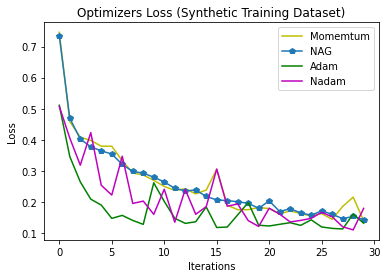

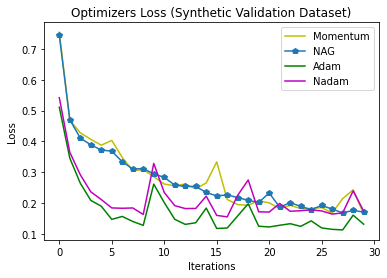

In [0]:
# Setting up the matplotlib plot:
x_axis = range(0,num_epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, synthetic_train_loss_Mo, 'y-', label="Momemtum")
ax.plot(x_axis, synthetic_train_loss_NAG, 'p-', label="NAG")
ax.plot(x_axis, synthetic_train_loss_Adam, 'g-', label="Adam")
ax.plot(x_axis, synthetic_train_loss_Nadam, 'm-', label="Nadam")
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Optimizers Loss (Synthetic Training Dataset)')
ax.legend()

fig, ay = plt.subplots()
ay.plot(x_axis, synthetic_val_loss_Mo, 'y-', label="Momentum")
ay.plot(x_axis, synthetic_val_loss_NAG, 'p-', label="NAG")
ay.plot(x_axis, synthetic_train_loss_Adam, 'g-', label="Adam")
ay.plot(x_axis, synthetic_val_loss_Adam, 'm-', label="Nadam")
ay.set_xlabel('Iterations')
ay.set_ylabel('Loss')
ay.set_title('Optimizers Loss (Synthetic Validation Dataset)')
ay.legend()

## Loading the benchmark (MNIST) dataset:

In [0]:
# MNIST Dataset (Input Piplines):
train_dataset = dsets.MNIST(root ='./data', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = dsets.MNIST(root ='./data', train = False, transform = transforms.ToTensor()) 

# Dataset Loaders (Input Piplines):
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,  batch_size = batch_size, shuffle = False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Statistics of benchmark (MNIST) datasets:

In [0]:
print(train_dataset, end='\n\n')
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Training the model for one epoch:

In [0]:
def train_epoch(loader, model):

    start_time = time.time()

    # Iterate through the batches in the loader:
    for i, (images, labels) in enumerate(loader): 
        images = Variable(images.view(-1, 28 * 28)).to(device) 
        labels = Variable(labels).to(device)

        # Forward + Backward + Optimize:
        optimizer.zero_grad() 
        outputs = model(images)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
    
    return (time.time() - start_time)

## Computing the average loss for one epoch:

In [0]:
def epoch_loss(loader, model, criterion):
    
    criterion_buffer = 0

    for i, (images, labels) in enumerate(loader): 
        images = Variable(images.view(-1, 28 * 28)).to(device) 
        labels = Variable(labels).to(device)
        
        outputs = model(images)

        criterion_buffer += criterion(outputs, labels).cpu().detach().numpy()
            
    return (criterion_buffer / (i+1))

## Evaluating the classification accuracy:

In [0]:
def classification_accuracy(loader, model, OptimType):

    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader):
        images = Variable(images.view(-1, 28 * 28)).to(device) 
        labels = Variable(labels).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum()

    print(f'MLP model accuracy of {total} benchmark datapoints using {OptimType} = {100 * correct / total: d}%')

## Training the model using benchmark datasets and different optimizers:

In [0]:
# -------------------------------------------------------------------
# Train the model with SGD optimizer using benchmark dataset:

# New model instance:
model = MLP(num_input, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

train_loss_SGD = np.zeros((num_epochs,1))
test_loss_SGD  = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = train_epoch(train_loader, model)
    computational_cost += diff_time

    # Computing the benchmark training and testing losses for one epoch:
    train_loss_SGD[epoch] = epoch_loss(train_loader, model, criterion)
    test_loss_SGD[epoch]  = epoch_loss(test_loader, model, criterion)

classification_accuracy(test_loader, model, 'SGD')
print(f'Computational training cost (MLP model + SGD) took ({computational_cost:.3f}) seconds.%', end='\n\n')

# -------------------------------------------------------------------
# Train the model with Adam optimizer using benchmark dataset:

# New model instance:
model = MLP(num_input, num_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas=(0.9, 0.99))
computational_cost = 0
diff_time = 0

train_loss_Adam = np.zeros((num_epochs,1))
test_loss_Adam  = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = train_epoch(train_loader, model)
    computational_cost += diff_time

    # Computing the benchmark training and testing losses for one epoch:
    train_loss_Adam[epoch] = epoch_loss(train_loader, model, criterion)
    test_loss_Adam[epoch]  = epoch_loss(test_loader, model, criterion)

classification_accuracy(test_loader, model, 'Adam')
print(f'Computational training cost (MLP model + Adam) took ({computational_cost:.3f}) seconds.%', end='\n\n')

# -------------------------------------------------------------------
# Train the model with AdaGrad optimizer using benchmark dataset:

# New model instance:
model = MLP(num_input, num_classes)
model.to(device)

optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

train_loss_AdaGrad = np.zeros((num_epochs,1))
test_loss_AdaGrad  = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = train_epoch(train_loader, model)
    computational_cost += diff_time

    # Computing the benchmark training and testing losses for one epoch:
    train_loss_AdaGrad[epoch] = epoch_loss(train_loader, model, criterion)
    test_loss_AdaGrad[epoch]  = epoch_loss(test_loader, model, criterion)

classification_accuracy(test_loader, model, 'AdaGrad')
print(f'Computational training cost (MLP model + AdaGrad) took ({computational_cost:.3f}) seconds.%', end='\n\n')

# -------------------------------------------------------------------
# Train the model with RMSProp optimizer using benchmark dataset:

# New model instance:
model = MLP(num_input, num_classes)
model.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

train_loss_RMSProp = np.zeros((num_epochs,1))
test_loss_RMSProp  = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = train_epoch(train_loader, model)
    computational_cost += diff_time

    # Computing the benchmark training and testing losses for one epoch:
    train_loss_RMSProp[epoch] = epoch_loss(train_loader, model, criterion)
    test_loss_RMSProp[epoch]  = epoch_loss(test_loader, model, criterion)

classification_accuracy(test_loader, model, 'RMSProp')
print(f'Computational training cost (MLP model + RMSProp) took ({computational_cost:.3f}) seconds.%', end='\n\n')

MLP model accuracy of 10000 benchmark datapoints using SGD =  94%
Computational training cost (MLP model + SGD) took (125.260) seconds.%

MLP model accuracy of 10000 benchmark datapoints using Adam =  97%
Computational training cost (MLP model + Adam) took (133.660) seconds.%

MLP model accuracy of 10000 benchmark datapoints using AdaGrad =  97%
Computational training cost (MLP model + AdaGrad) took (126.882) seconds.%

MLP model accuracy of 10000 benchmark datapoints using RMSProp =  96%
Computational training cost (MLP model + RMSProp) took (127.371) seconds.%



### Train with Momentum

In [0]:
# -------------------------------------------------------------------
# Train the model with SGD momentum optimizer using benchmark dataset:

# New model instance:
model = MLP(num_input, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum= beta1)
computational_cost = 0
diff_time = 0

train_loss_Mo = np.zeros((num_epochs,1))
test_loss_Mo  = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = train_epoch(train_loader, model)
    computational_cost += diff_time

    # Computing the benchmark training and testing losses for one epoch:
    train_loss_Mo[epoch] = epoch_loss(train_loader, model, criterion)
    test_loss_Mo[epoch]  = epoch_loss(test_loader, model, criterion)

classification_accuracy(test_loader, model, 'Momentum')
print(f'Computational training cost (MLP model + Momentum) took ({computational_cost:.3f}) seconds.%', end='\n\n')



MLP model accuracy of 10000 benchmark datapoints using Momentum =  98%
Computational training cost (MLP model + Momentum) took (124.863) seconds.%



### Train with NAG

In [0]:
#-------------------------------------------------------------------
# Train the model with NAG using benchmark dataset:

# New model instance:
model = MLP(num_input, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum= beta1, nesterov=True)
computational_cost = 0
diff_time = 0

train_loss_NAG = np.zeros((num_epochs,1))
test_loss_NAG  = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = train_epoch(train_loader, model)
    computational_cost += diff_time

    # Computing the benchmark training and testing losses for one epoch:
    train_loss_NAG[epoch] = epoch_loss(train_loader, model, criterion)
    test_loss_NAG[epoch]  = epoch_loss(test_loader, model, criterion)

classification_accuracy(test_loader, model, 'NAG')
print(f'Computational training cost (MLP model + NAG) took ({computational_cost:.3f}) seconds.%', end='\n\n')



MLP model accuracy of 10000 benchmark datapoints using NAG =  97%
Computational training cost (MLP model + NAG) took (125.649) seconds.%



###Train with Nadam

In [0]:
#-------------------------------------------------------------------
# Train the model with NAG using benchmark dataset:

# New model instance:
model = MLP(num_input, num_classes)
model.to(device)

optimizer = Nadam(model.parameters(), lr = learning_rate)
computational_cost = 0
diff_time = 0

train_loss_Nadam = np.zeros((num_epochs,1))
test_loss_Nadam  = np.zeros((num_epochs,1))

for epoch in range(num_epochs):
    # Training the Model:
    diff_time = train_epoch(train_loader, model)
    computational_cost += diff_time

    # Computing the benchmark training and testing losses for one epoch:
    train_loss_Nadam[epoch] = epoch_loss(train_loader, model, criterion)
    test_loss_Nadam[epoch]  = epoch_loss(test_loader, model, criterion)

classification_accuracy(test_loader, model, 'Nadam')
print(f'Computational training cost (Nadam) took ({computational_cost:.3f}) seconds.%', end='\n\n')



MLP model accuracy of 10000 benchmark datapoints using Nadam =  96%
Computational training cost (Nadam) took (130.937) seconds.%



## Plotting the benchmark losses:

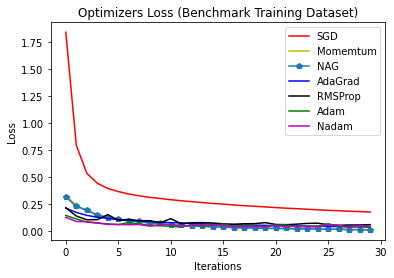

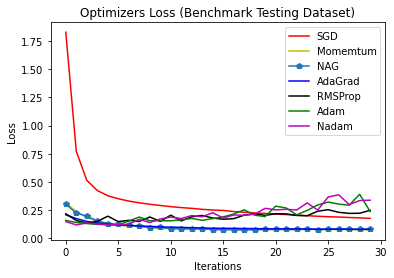

In [0]:
# Setting up the matplotlib plot:

fig, aw = plt.subplots()
aw.plot(x_axis, train_loss_SGD, 'r-', label="SGD")
aw.plot(x_axis, train_loss_Mo, 'y-', label="Momemtum")
aw.plot(x_axis, train_loss_NAG, 'p-', label="NAG")
aw.plot(x_axis, train_loss_AdaGrad, 'b-', label="AdaGrad")
aw.plot(x_axis, train_loss_RMSProp, 'k-', label="RMSProp")
aw.plot(x_axis, train_loss_Adam, 'g-', label="Adam")
aw.plot(x_axis, train_loss_Nadam, 'm-', label="Nadam")
aw.set_xlabel('Iterations')
aw.set_ylabel('Loss')
aw.set_title('Optimizers Loss (Benchmark Training Dataset)')
aw.legend()

fig, az = plt.subplots()
az.plot(x_axis, test_loss_SGD, 'r-', label="SGD")
az.plot(x_axis, test_loss_Mo, 'y-', label="Momemtum")
az.plot(x_axis, test_loss_NAG, 'p-', label="NAG")
az.plot(x_axis, test_loss_AdaGrad, 'b-', label="AdaGrad")
az.plot(x_axis, test_loss_RMSProp, 'k-', label="RMSProp")
az.plot(x_axis, test_loss_Adam, 'g-', label="Adam")
az.plot(x_axis, test_loss_Nadam, 'm-', label="Nadam")
az.set_xlabel('Iterations')
az.set_ylabel('Loss')
az.set_title('Optimizers Loss (Benchmark Testing Dataset)')
az.legend()

<br>

---

### Experiment With Synthetic Online Learning Data

###### Create dataset and hyper parameters.

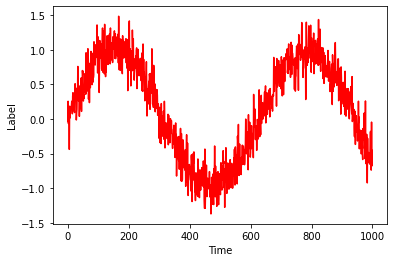

In [71]:
T = 1000 # Generate 1,000 datapoints
time = np.arange(0, T)
num_epochs = 30
# Define the target function
f = np.sin(0.01 * time) + 0.2 * np.random.normal(size=T)
# Let's plot the target function, f
fig, ax = plt.subplots()
ax.plot(time, f, 'r')

# Now let's construct a dataset that we can train a model on...
ax.set_xlabel('Time')
ax.set_ylabel('Label')
tau = 4 # The history length
n_train=100

In [0]:
# Create dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
class TargetData(Dataset):
    def __init__(self, num_points):
        # Now let's construct a dataset that we can train a model on...
        T = num_points # Generate datapoints for training
        print("Sequential size: ",T)
        time = np.arange(0, T)
        f = np.sin(0.01 * time) + 0.2 * np.random.normal(size=T)
        tau = 4 # The history length
        self.features = np.zeros((T-tau, tau))
        for i in range(tau):
            self.features[:, i] = f[i: T-tau+i]
            self.labels = f[tau:]
        
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        
        return {'features': x, 'label': y}
    
    def __len__(self):
        return len(self.features)

##### Online Learning Experiment

In [0]:
def train_net(net, train_iter, epochs, lr,optimizer):
    criterion = nn.MSELoss()
    loss_train = 0.
    for epoch in range(epochs):
        running_loss = 0.
        i = 1
        for batch in train_iter:
            features = batch['features'].requires_grad_(True)
            label = batch['label']
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(features.float())
            loss = criterion(outputs, label.reshape((-1, 1)))
            loss.backward()
            optimizer.step()

            # Print stats
            running_loss += loss.item()
            i += 1
        loss_train = running_loss/i
    return loss_train

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, num_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(num_features, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.output(x)
        return x

In [75]:
net = MLP(4)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
step = int(n_train/tau)
online_loss_SGD = np.zeros((step,1))
for i in range(1,step):
  train = TargetData(i*tau)
  train_iter = DataLoader(train, batch_size=1)
  loss = train_net(net, train_iter, num_epochs, learning_rate,optimizer)
  online_loss_SGD[i]=(loss)

Sequential size:  4
Sequential size:  8
Sequential size:  12
Sequential size:  16
Sequential size:  20
Sequential size:  24
Sequential size:  28
Sequential size:  32
Sequential size:  36
Sequential size:  40
Sequential size:  44
Sequential size:  48
Sequential size:  52
Sequential size:  56
Sequential size:  60
Sequential size:  64
Sequential size:  68
Sequential size:  72
Sequential size:  76
Sequential size:  80
Sequential size:  84
Sequential size:  88
Sequential size:  92
Sequential size:  96


In [0]:
# Test value
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = f[i: T-tau+i]
labels = f[tau:]
features[0]
labels[0]
net.eval()
estimates_SGD = net(torch.tensor(features).float())
estimates_SGD = estimates_SGD.detach().numpy().reshape(-1,)

In [77]:
# Train with Momentum
net = MLP(4)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=beta1)
n_train=100
step = int(n_train/tau)
online_loss_Mo = np.zeros((step,1))
for i in range(1,step):
  train = TargetData(i*tau)
  train_iter = DataLoader(train, batch_size=1)
  loss = train_net(net, train_iter,num_epochs, learning_rate,optimizer)
  online_loss_Mo[i]=loss

Sequential size:  4
Sequential size:  8
Sequential size:  12
Sequential size:  16
Sequential size:  20
Sequential size:  24
Sequential size:  28
Sequential size:  32
Sequential size:  36
Sequential size:  40
Sequential size:  44
Sequential size:  48
Sequential size:  52
Sequential size:  56
Sequential size:  60
Sequential size:  64
Sequential size:  68
Sequential size:  72
Sequential size:  76
Sequential size:  80
Sequential size:  84
Sequential size:  88
Sequential size:  92
Sequential size:  96


In [0]:
# Test value
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = f[i: T-tau+i]
labels = f[tau:]
features[0]
labels[0]
net.eval()
estimates_Mo = net(torch.tensor(features).float())
estimates_Mo = estimates_Mo.detach().numpy().reshape(-1,)

In [79]:
# Train with NAG
net = MLP(4)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=beta1,nesterov=True)
n_train=100
step = int(n_train/tau)
online_loss_NAG = np.zeros((step,1))
for i in range(1,step):
  train = TargetData(i*tau)
  train_iter = DataLoader(train, batch_size=1)
  loss = train_net(net, train_iter, num_epochs, learning_rate,optimizer)
  online_loss_NAG[i]=loss

Sequential size:  4
Sequential size:  8
Sequential size:  12
Sequential size:  16
Sequential size:  20
Sequential size:  24
Sequential size:  28
Sequential size:  32
Sequential size:  36
Sequential size:  40
Sequential size:  44
Sequential size:  48
Sequential size:  52
Sequential size:  56
Sequential size:  60
Sequential size:  64
Sequential size:  68
Sequential size:  72
Sequential size:  76
Sequential size:  80
Sequential size:  84
Sequential size:  88
Sequential size:  92
Sequential size:  96


In [0]:
# Test value
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = f[i: T-tau+i]
labels = f[tau:]
features[0]
labels[0]
net.eval()
estimates_NAG = net(torch.tensor(features).float())
estimates_NAG = estimates_NAG.detach().numpy().reshape(-1,)

In [81]:
net = MLP(4)
optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
n_train=100
step = int(n_train/tau)
online_loss_RMS = np.zeros((step,1))
for i in range(1,step):
  train = TargetData(i*tau)
  train_iter = DataLoader(train, batch_size=1)
  loss = train_net(net, train_iter,num_epochs, learning_rate,optimizer)
  online_loss_RMS[i]=loss

Sequential size:  4
Sequential size:  8
Sequential size:  12
Sequential size:  16
Sequential size:  20
Sequential size:  24
Sequential size:  28
Sequential size:  32
Sequential size:  36
Sequential size:  40
Sequential size:  44
Sequential size:  48
Sequential size:  52
Sequential size:  56
Sequential size:  60
Sequential size:  64
Sequential size:  68
Sequential size:  72
Sequential size:  76
Sequential size:  80
Sequential size:  84
Sequential size:  88
Sequential size:  92
Sequential size:  96


In [0]:
# Test value
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = f[i: T-tau+i]
labels = f[tau:]
features[0]
labels[0]
net.eval()
estimates_RMS = net(torch.tensor(features).float())
estimates_RMS = estimates_RMS.detach().numpy().reshape(-1,)

In [83]:
# Train with Adam
net = MLP(4)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
n_train=100
step = int(n_train/tau)
online_loss_Adam = np.zeros((step,1))
for i in range(1,step):
  train = TargetData(i*tau)
  train_iter = DataLoader(train, batch_size=1)
  loss = train_net(net, train_iter, num_epochs, learning_rate,optimizer)
  online_loss_Adam[i]=loss

Sequential size:  4
Sequential size:  8
Sequential size:  12
Sequential size:  16
Sequential size:  20
Sequential size:  24
Sequential size:  28
Sequential size:  32
Sequential size:  36
Sequential size:  40
Sequential size:  44
Sequential size:  48
Sequential size:  52
Sequential size:  56
Sequential size:  60
Sequential size:  64
Sequential size:  68
Sequential size:  72
Sequential size:  76
Sequential size:  80
Sequential size:  84
Sequential size:  88
Sequential size:  92
Sequential size:  96


In [0]:
# Test value
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = f[i: T-tau+i]
labels = f[tau:]
features[0]
labels[0]
net.eval()
estimates_Adam = net(torch.tensor(features).float())
estimates_Adam = estimates_Adam.detach().numpy().reshape(-1,)

In [85]:
# Train with Adagrad
net = MLP(4)
optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate)
n_train=100
step = int(n_train/tau)
online_loss_Adagrad = np.zeros((step,1))
for i in range(1,step):
  train = TargetData(i*tau)
  train_iter = DataLoader(train, batch_size=1)
  loss = train_net(net, train_iter, num_epochs, learning_rate,optimizer)
  online_loss_Adagrad[i]=loss

Sequential size:  4
Sequential size:  8
Sequential size:  12
Sequential size:  16
Sequential size:  20
Sequential size:  24
Sequential size:  28
Sequential size:  32
Sequential size:  36
Sequential size:  40
Sequential size:  44
Sequential size:  48
Sequential size:  52
Sequential size:  56
Sequential size:  60
Sequential size:  64
Sequential size:  68
Sequential size:  72
Sequential size:  76
Sequential size:  80
Sequential size:  84
Sequential size:  88
Sequential size:  92
Sequential size:  96


In [0]:
# Test value
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = f[i: T-tau+i]
labels = f[tau:]
features[0]
labels[0]
net.eval()
estimates_Adagrad = net(torch.tensor(features).float())
estimates_Adagrad = estimates_Adagrad.detach().numpy().reshape(-1,)

In [87]:
# Train with Nadam
net = MLP(4)
optimizer = Nadam(net.parameters(), lr = learning_rate)
n_train=100
step = int(n_train/tau)
online_loss_Nadam = np.zeros((step,1))
for i in range(1,step):
  train = TargetData(i*tau)
  train_iter = DataLoader(train, batch_size=1)
  loss = train_net(net, train_iter, num_epochs, learning_rate,optimizer)
  online_loss_Nadam[i]=loss

Sequential size:  4
Sequential size:  8
Sequential size:  12
Sequential size:  16
Sequential size:  20
Sequential size:  24
Sequential size:  28
Sequential size:  32
Sequential size:  36
Sequential size:  40
Sequential size:  44
Sequential size:  48
Sequential size:  52
Sequential size:  56
Sequential size:  60
Sequential size:  64
Sequential size:  68
Sequential size:  72
Sequential size:  76
Sequential size:  80
Sequential size:  84
Sequential size:  88
Sequential size:  92
Sequential size:  96


In [0]:
# Test value
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = f[i: T-tau+i]
labels = f[tau:]
features[0]
labels[0]
net.eval()
estimates_Nadam = net(torch.tensor(features).float())
estimates_Nadam = estimates_Nadam.detach().numpy().reshape(-1,)

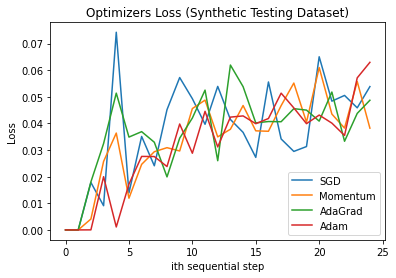

In [89]:
x_axis = range(0,step)
# Plot loss value
fig, ao = plt.subplots()
ao.plot(x_axis, online_loss_SGD, label="SGD")
#ao.plot(x_axis, online_loss_NAG, label="NAG")
ao.plot(x_axis, online_loss_Mo, label="Momentum")
ao.plot(x_axis, online_loss_Adagrad, label="AdaGrad")
#ao.plot(x_axis, online_loss_RMS, label="RMSProp")
ao.plot(x_axis, online_loss_Adam, label="Adam")
#ao.plot(x_axis, online_loss_Nadam, label="Nadam")
ao.set_xlabel('ith sequential step')
ao.set_ylabel('Loss')
ao.set_title('Optimizers Loss (Synthetic Testing Dataset)')
ao.legend()

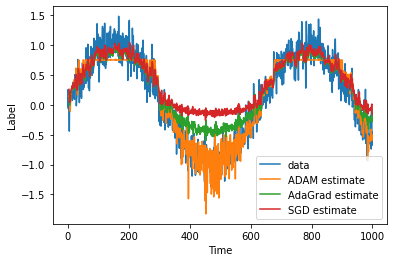

In [92]:
# Let's plot our estimates against the target function
fig, ax = plt.subplots()
ax.plot(time, f, label='data')
#ax.plot(time[tau:], estimates_Nadam, label='Nadam estimate')
#ax.plot(time[tau:], estimates_NAG, label='NAG estimate')
ax.plot(time[tau:], estimates_Adam,label='ADAM estimate')
#ax.plot(time[tau:], estimates_Mo, label='Momentum estimate')
#ax.plot(time[tau:], estimates_RMS, label='RMSProp estimate')
ax.plot(time[tau:], estimates_Adagrad, label='AdaGrad estimate')
ax.plot(time[tau:], estimates_SGD, label='SGD estimate')
handles, names = ax.get_legend_handles_labels()
ax.set_xlabel('Time')
ax.set_ylabel('Label')
ax.legend(handles, names)

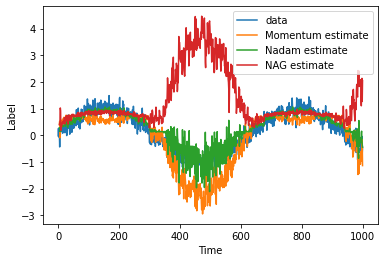

In [91]:
# Let's plot our estimates against the target function
fig, ax = plt.subplots()
ax.plot(time, f, label='data')
ax.plot(time[tau:], estimates_Mo, label='Momentum estimate')
#ax.plot(time[tau:], estimates_RMS, label='RMSProp estimate')
ax.plot(time[tau:], estimates_Nadam, label='Nadam estimate')
ax.plot(time[tau:], estimates_NAG, label='NAG estimate')
#ax.plot(time[tau:], estimates_Adam,label='ADAM estimate')
handles, names = ax.get_legend_handles_labels()
ax.set_xlabel('Time')
ax.set_ylabel('Label')
ax.legend(handles, names)

PyTorch model original copyright (c) 2019 Yunjey Choi   
Modifications copyright (c) 2019 Ted Willke